In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')

I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework

In [2]:
data_set = coor_data.join(date_data.join(meta_data))

In [131]:

Y_data = data_set[['endx','endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy', 'start_date', 'class']).to_numpy()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

sc = MinMaxScaler(feature_range=(0,1))
X_data_n = sc.fit_transform(X_data)
Y_data_n = sc.fit_transform(Y_data)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.3, random_state=30, shuffle = False)

In [134]:
from tensorflow.keras import layers, Model
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4,))
inputB = layers.Input(shape=(62,))

x = Dense(32, activation="softmax")(inputA)
x = Model(inputs=inputA, outputs=x)
y = Dense(24, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

z = Dense(2)(x.output)

model = Model(inputs=x.input, outputs=z)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [135]:

from tensorflow.python.keras.callbacks import EarlyStopping

def error_avg_km(y_true, y_pred):
    absolute = abs(y_true - y_pred)
    return tf.reduce_mean(absolute*111, axis=-1)
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[error_avg_km])

callback = EarlyStopping(monitor='loss', patience=3, mode="auto")
model.fit([x_train[:,0:4],x_train], y_train, epochs=1000, validation_data=([x_test[:,0:4],x_test], y_test), callbacks=[callback])

Train on 321634 samples, validate on 137844 samples
Epoch 1/1000
321634/321634 [==============================] - 9s 27us/sample - loss: 0.0319 - error_avg_km: 3.5421 - val_loss: 0.0192 - val_error_avg_km: 2.1305
Epoch 2/1000
321634/321634 [==============================] - 9s 27us/sample - loss: 0.0192 - error_avg_km: 2.1258 - val_loss: 0.0194 - val_error_avg_km: 2.1570
Epoch 3/1000
321634/321634 [==============================] - 9s 27us/sample - loss: 0.0190 - error_avg_km: 2.1056 - val_loss: 0.0188 - val_error_avg_km: 2.0883
Epoch 4/1000
321634/321634 [==============================] - 9s 27us/sample - loss: 0.0189 - error_avg_km: 2.1033 - val_loss: 0.0189 - val_error_avg_km: 2.0947
Epoch 5/1000
321634/321634 [==============================] - 10s 30us/sample - loss: 0.0189 - error_avg_km: 2.1015 - val_loss: 0.0195 - val_error_avg_km: 2.1637
Epoch 6/1000
321634/321634 [==============================] - 10s 30us/sample - loss: 0.0189 - error_avg_km: 2.0991 - val_loss: 0.0188 - val_e

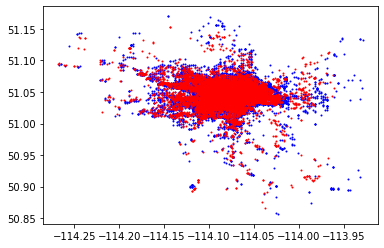

In [136]:
import matplotlib.pyplot as plt

sc.fit_transform(Y_data)
result_Y = model.predict([x_test[:,0:4],x_test])


result_Y_plot = sc.inverse_transform(result_Y)
y_test_plot = sc.inverse_transform(y_test)
plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



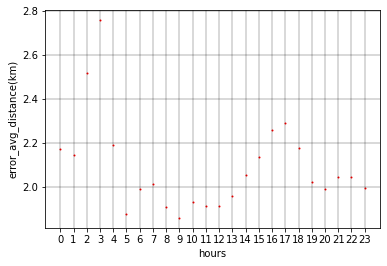

In [139]:
mae_rate_hour = []

sc.fit_transform(X_data)
for index in range(24):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,2] > (index)-0.1, sc.inverse_transform(x_test)[:,2] < (index+1)-0.5)
    result_Y_hour = result_Y[mask]
    Y_test_in = y_test[mask]
    error = abs(result_Y_hour - Y_test_in)
    endx = sum(error[:,0])/len(error)
    endy = sum(error[:,1])/len(error)
    error_average_distance = (endx+endy)/2

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(round(error_average_distance*111,4)), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


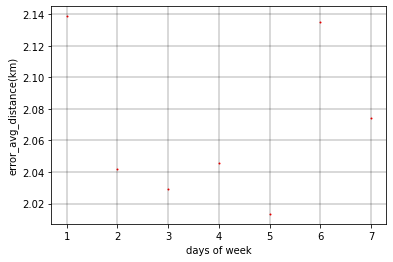

In [138]:
mae_rate_day_of_week = []

sc.fit_transform(X_data)
for index in range(7):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,3] > (index)-0.1, sc.inverse_transform(x_test)[:,3] < (index+1)-0.5)
    result_Y_day_of_week = result_Y[mask]
    Y_test_in = y_test
    error = abs(result_Y_day_of_week - Y_test_in[mask])
    endx = sum(error[:,0])/len(error)
    endy = sum(error[:,1])/len(error)
    error_average_distance = (endx+endy)/2

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([float(round(error_average_distance*111,4)), str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)